In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from marbleri.models import BaseConvNet
from marbleri.process import get_hwrf_filenames
from marbleri.nwp import HWRFStep, BestTrackNetCDF
from sklearn.metrics import mean_absolute_error
from glob import glob
from os.path import join, exists
import pandas as pd
from matplotlib.colors import LogNorm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import save_model
from marbleri.training import partition_storm_examples
%matplotlib inline


/glade/work/dgagne/ncar_pylib_dl_10/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
print(tf.__version__)

1.13.1


In [3]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.experimental.list_physical_devices())
except AttributeError:
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    K.set_session(tf.Session(config=tf_config))


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [5]:
get_available_gpus()

['/device:GPU:0']

In [6]:
rank = 0
np.random.seed(34343)
best_track = pd.read_csv("/glade/scratch/dgagne/hfip/processed_data_dv_lossy/best_track_all.csv", index_col="Index")
print("original best track count", best_track.shape[0])
out_col = "dvmax_bt_12"
best_track = best_track.loc[np.abs(best_track[out_col]) < 1000, :].reset_index(drop=True)
print("filtered best track count", best_track.shape[0])
train_rank_indices, val_rank_indices = partition_storm_examples(best_track, 1,
                                                                0.2)

original best track count 51969
filtered best track count 48876


In [7]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/"
hwrf_files = get_hwrf_filenames(best_track, hwrf_path)

In [4]:
['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [8]:
input_var_levels = []
m_vars = ["THETA_E_L100", "U_RAD_L100", "V_TAN_L100"]
s_vars = ["TCOLC_E_L103"]
p_levs = [20000, 85000]
for m_var in m_vars:
    for p_lev in p_levs:
        input_var_levels.append((m_var, p_lev))
for s_var in s_vars:
    input_var_levels.append((s_var, None))

In [8]:
train_files = hwrf_files[train_rank_indices[0]]
data = []
step_data = []
available_hwrf_files = []
for t, train_file in enumerate(train_files):
    if t % 100 == 0:
        print(train_file)
    if exists(train_file):
        available_hwrf_files.append(t)
        step = HWRFStep(train_file)
        for var in input_var_levels:
            step_data.append(step.get_variable(var[0], level=var[1]).values)
        step.close()
        del step
        data.append(np.stack(step_data, axis=-1))
        del step_data[:]
train_data = np.stack(data, axis=0)

/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest01l.2015050700.f015.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest01l.2015050718.f063.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/ana01l.2015050818.f015.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/ana01l.2015051006.f024.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest01l.2016011312.f048.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest02l.2016052712.f030.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/two02l.2016052818.f063.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/bonnie02l.2016053006.f045.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/bonnie02l.2016060212.f051.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/bonnie02l.2016060312.f072.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest03l.2015071312.f015.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest03l.2017061812.f057.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/three03l.2017062006.f054

In [20]:
del data[:]

In [21]:
val_files = hwrf_files[val_rank_indices[0]]
data = []
step_data = []
available_val_hwrf_files = []
for v, val_file in enumerate(val_files):
    if v % 100 == 0:
        print(val_file)
    if exists(val_file):
        available_val_hwrf_files.append(v)
        step = HWRFStep(val_file)
        for var in input_var_levels:
            step_data.append(step.get_variable(var[0], level=var[1]).values)
        step.close()
        data.append(np.stack(step_data, axis=-1))
        del step_data[:]
val_data = np.stack(data, axis=0)

/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/alex01l.2016011400.f003.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/erika05l.2015082506.f009.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/fiona06l.2016081718.f015.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/fiona06l.2016081818.f036.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/fiona06l.2016081918.f012.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/fiona06l.2016082100.f015.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/seven07l.2015090518.f036.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest10l.2016091118.f096.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest12l.2016091406.f006.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/katia13l.2017090618.f018.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/matthew14l.2016092900.f036.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/matthew14l.2016092912.f108.nc
/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/matthew14l.2016093006.

In [11]:
train_rank_indices[0].shape

(39491,)

In [22]:
val_rank_indices[0].shape

(9385,)

In [15]:
norm_train_data = np.zeros(train_data.shape, dtype=np.float32)
train_scaling = np.zeros((train_data.shape[-1], 2), dtype=np.float32)
for c in range(norm_train_data.shape[-1]):
    train_scaling[c, 0] = np.nanmean(train_data[:, :, :, c])
    train_scaling[c, 1] = np.nanstd(train_data[:, :, :, c])
    norm_train_data[:, :, :, c] = (train_data[:, :, :, c] - train_scaling[c, 0]) / train_scaling[c, 1]
norm_train_data[np.isnan(train_data)] = 0

In [24]:
norm_val_data = np.zeros(val_data.shape, dtype=np.float32)
for c in range(norm_val_data.shape[-1]):
    norm_val_data[:, :, :, c] = (val_data[:, :, :, c] - train_scaling[c, 0]) / train_scaling[c, 1]
norm_val_data[np.isnan(val_data)] = 0

In [25]:
bt_train_indices = train_rank_indices[0][available_hwrf_files]
bt_val_indices = val_rank_indices[0][available_val_hwrf_files]

In [64]:
val_rank_indices[0]

array([  422,   423,   424, ..., 48873, 48874, 48875])

In [4]:
norm_train_data = np.random.normal(size=(train_rank_indices[0].size, 32, 32, 3)).astype(np.float32)

In [42]:
bcn = BaseConvNet(min_filters=16, filter_growth_rate=1.5, filter_width=3, pooling="max", data_format="channels_last",
             verbose=1, loss="mae", batch_size=128, epochs=10)
bcn.fit(norm_train_data, best_track[out_col].values[train_rank_indices[0]])

Conv input shape (125, 126, 7)
5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 125, 126, 7)]     0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 125, 126, 16)      1024      
_________________________________________________________________
hidden_activation_00 (Activa (None, 125, 126, 16)      0         
_________________________________________________________________
pooling_00 (MaxPooling2D)    (None, 62, 63, 16)        0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 62, 63, 24)        3480      
_________________________________________________________________
hidden_activation_01 (Activa (None, 62, 63, 24)        0         
_________________________________________________________________
pooling_01 (MaxPooling2D) 

In [143]:
save_model(bcn.model, "hwrf_base_cnn.h5", save_format="h5")

In [44]:
preds = bcn.model.predict(norm_val_data)

In [49]:
preds.shape

(9385, 1)

In [48]:
best_track[out_col].values[val_rank_indices[0]].shape

(9385,)

In [51]:
mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds)

7.2747380398712025

In [88]:
fhours = best_track.loc[val_rank_indices[0], "TIME"].values
dvs = best_track[out_col].values[bt_val_indices]
unique_fhours = np.unique(fhours)
maes = np.zeros(unique_fhours.shape)
for f, fh in enumerate(unique_fhours):
    idxs = fhours == fh
    print(fh, np.count_nonzero(idxs))
    maes[f] = mean_absolute_error(dvs[idxs], preds.ravel()[idxs])

3 339
6 357
9 346
12 355
15 345
18 340
21 327
24 320
27 308
30 305
33 291
36 294
39 268
42 276
45 269
48 258
51 253
54 253
57 242
60 242
63 227
66 221
69 221
72 216
75 205
78 207
81 197
84 200
87 191
90 190
93 179
96 170
99 165
102 166
105 161
108 170
111 157
114 154


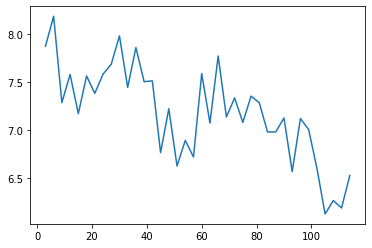

In [89]:
plt.plot(unique_fhours, maes)

In [70]:
np.intersect1d(bt_train_indices, bt_val_indices)

array([], dtype=int64)

In [81]:
plt.pcolormesh(norm_train_data[:, :, :, 7].mean(axis=0))

IndexError: index 7 is out of bounds for axis 3 with size 7

In [138]:
np.corrcoef(best_track[out_col].values[val_rank_indices[0]], preds.ravel())

array([[1.        , 0.38679496],
       [0.38679496, 1.        ]])

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


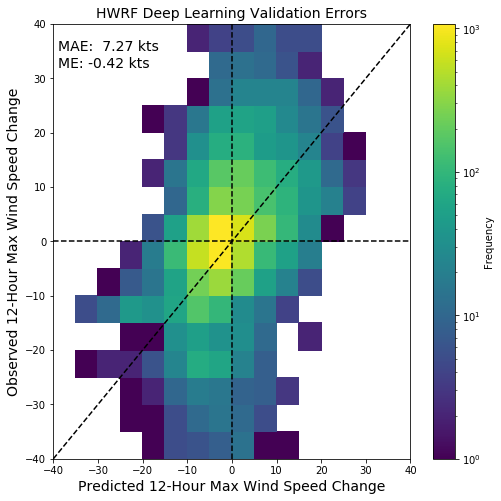

In [140]:
mae = mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds.ravel())
me = np.mean(best_track[out_col].values[val_rank_indices[0]] - preds.ravel())
plt.figure(figsize=(8, 8))
plt.hist2d(preds.ravel(), dvs, bins=np.arange(-40, 45, 5), cmin=1, norm=LogNorm())
diag = np.arange(-40, 45, 5)
plt.plot(diag, diag, 'k--')
plt.plot(np.zeros(diag.shape), diag, 'k--')
plt.plot(diag, np.zeros(diag.shape), 'k--')
plt.text(-39, 35, f"MAE: {mae: 0.2f} kts", fontsize=14)
plt.text(-39, 32, f"ME: {me: 0.2f} kts", fontsize=14)
plt.xlabel("Predicted 12-Hour Max Wind Speed Change", fontsize=14)
plt.ylabel("Observed 12-Hour Max Wind Speed Change", fontsize=14)
plt.colorbar(label="Frequency")
plt.title("HWRF Deep Learning Validation Errors", fontsize=14)
plt.savefig("hwrf_cnn_error_hist.png", dpi=200, bbox_inches="tight")

(array([  13.,   36.,   49.,   67.,  139.,  181.,  343.,  819., 2028.,
         695., 2631.,  937.,  727.,  308.,  210.,  103.,   41.,   32.,
          13.,   13.]),
 array([-45. , -40.5, -36. , -31.5, -27. , -22.5, -18. , -13.5,  -9. ,
         -4.5,   0. ,   4.5,   9. ,  13.5,  18. ,  22.5,  27. ,  31.5,
         36. ,  40.5,  45. ]),
 <a list of 20 Patch objects>)

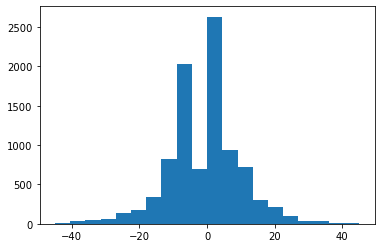

In [84]:
plt.hist(dvs, bins=20)

In [96]:
from sklearn.metrics import confusion_matrix

array([[4634, 2049],
       [ 996, 1706]])

In [100]:
class ContingencyTable(object):
    """
    Initializes a binary contingency table and generates many skill scores.

    Args:
        a: true positives
        b: false positives
        c: false negatives
        d: true negatives

    Attributes:
        table (numpy.ndarray): contingency table
        N: total number of items in table

    """
    def __init__(self, a, b, c, d):
        self.table = np.array([[a, b], [c, d]], dtype=float)
        self.N = self.table.sum()

    def update(self, a, b, c, d):
        """
        Update contingency table with new values without creating a new object.
        """
        self.table.ravel()[:] = [a, b, c, d]
        self.N = self.table.sum()

    def __add__(self, other):
        """
        Add two contingency tables together and return a combined one.

        Args:
            other: Another contingency table

        Returns:
            Sum of contingency tables
        """
        sum_ct = ContingencyTable(*(self.table + other.table).tolist())
        return sum_ct

    def pod(self):
        """
        Probability of Detection (POD) or Hit Rate.
        Formula:  a/(a+c)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[1, 0])

    def foh(self):
        """
        Frequency of Hits (FOH) or Success Ratio.
        Formula:  a/(a+b)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1])

    def far(self):
        """
        False Alarm Ratio (FAR).
        Formula:  b/(a+b)
        """
        return self.table[0, 1] / (self.table[0, 0] + self.table[0, 1])

    def pofd(self):
        """
        Probability of False Detection (POFD).
        b/(b+d)
        """
        return self.table[0, 1] / (self.table[0, 1] + self.table[1, 1])

    def fom(self):
        """
        Frequency of Misses (FOM).
        Formula:  c/(a+c)."""
        return self.table[1, 0] / (self.table[0, 0] + self.table[1, 0])

    def dfr(self):
        """Returns Detection Failure Ratio (DFR).
           Formula:  c/(c+d)"""
        return self.table[1, 0] / (self.table[1, 0] + self.table[1, 1])

    def pon(self):
        """Returns Probability of Null (PON).
           Formula:  d/(b+d)"""
        return self.table[1, 1] / (self.table[0, 1] + self.table[1, 1])

    def focn(self):
        """Returns Frequency of Correct Null (FOCN).
           Formula:  d/(c+d)"""
        return self.table[1, 1] / (self.table[1, 0] + self.table[1, 1])

    def bias(self):
        """
        Frequency Bias.
        Formula:  (a+b)/(a+c)"""
        return (self.table[0, 0] + self.table[0, 1]) / (self.table[0, 0] + self.table[1, 0])

    def accuracy(self):
        """Finley's measure, fraction correct, accuracy (a+d)/N"""
        return (self.table[0, 0] + self.table[1, 1]) / self.N

    def csi(self):
        """Gilbert's Score or Threat Score or Critical Success Index a/(a+b+c)"""
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0])

    def ets(self):
        """Equitable Threat Score, Gilbert Skill Score, v, (a - R)/(a + b + c - R), R=(a+b)(a+c)/N"""
        r = (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 0] + self.table[1, 0]) / self.N
        return (self.table[0, 0] - r) / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0] - r)

    def hss(self):
        """Doolittle (Heidke) Skill Score.  2(ad-bc)/((a+b)(b+d) + (a+c)(c+d))"""
        return 2 * (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / (
            (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 1] + self.table[1, 1]) +
            (self.table[0, 0] + self.table[1, 0]) * (self.table[1, 0] + self.table[1, 1]))

    def pss(self):
        """Peirce (Hansen-Kuipers, True) Skill Score (ad - bc)/((a+c)(b+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[1, 0]) * (self.table[0, 1] + self.table[1, 1]))

    def css(self):
        """Clayton Skill Score (ad - bc)/((a+b)(c+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[0, 1]) * (self.table[1, 0] + self.table[1, 1]))

    def __str__(self):
        table_string = '\tEvent\n\tYes\tNo\nYes\t%d\t%d\nNo\t%d\t%d\n' % (
            self.table[0, 0], self.table[0, 1], self.table[1, 0], self.table[1, 1])
        return table_string


In [102]:
cm = confusion_matrix(np.where(dvs > 0, 1, 0), np.where(preds.ravel() > 0, 1, 0))
ct = ContingencyTable(*cm.T.ravel().tolist())

In [106]:
dv_bin = np.where(dvs > 0, 1, 0) 
preds_bin = np.where(preds.ravel() > 0, 1, 0)
tp = np.count_nonzero((preds_bin == 1) & (dv_bin == 1))
fp = np.count_nonzero((preds_bin == 1) & (dv_bin == 0))
fn = np.count_nonzero((preds_bin == 0) & (dv_bin == 1))
tn = np.count_nonzero((preds_bin == 0) & (dv_bin == 0))

In [107]:
ct2 = ContingencyTable(tp, fp, fn, tn)

In [109]:
print(ct2)

	Event
	Yes	No
Yes	1706	2049
No	996	4634



In [116]:
ct2.pofd()

0.30659883285949424